# Classificação de partidas de xadrez

Serão criados modelos de classificação para prever o vencedor de partidas de xadrez, baseado em dados pré-processados no projeto anterior.

Será utilizado o MLFlow para rastreamento de experimentos e comparação de modelos.

# Configuração do MLFLow

In [1]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
import mlflow
import mlflow.sklearn
import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

mlflow.set_experiment(experiment_name='Chess games classification')

2024/07/08 23:28:47 INFO mlflow.tracking.fluent: Experiment with name 'Chess games classification' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/Arquivos/Documentos/Faculdade/7p/Intro%20dados/intro-dados/notebooks/mlruns/289299321287379343', creation_time=1720492127273, experiment_id='289299321287379343', last_update_time=1720492127273, lifecycle_stage='active', name='Chess games classification', tags={}>

Definição do método de rastreamento do mlflow:

In [3]:
def mlflow_track(model, model_name: str, params: dict, metrics: dict):
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(sk_model=model, artifact_path="sklearn-model", registered_model_name=model_name)

Definição do método para plotar resultados do treinamento de um modelo

In [4]:
def plot_grid_search(results: dict[str, np.ndarray], param: str):
    plt.figure(figsize=(10, 10))
    plt.title("GridSearchCV evaluating", fontsize=16)

    plt.xlabel(param)
    plt.ylabel("Accuracy Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_%s" % param].data, dtype=float)

    ax = plt.gca()

    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_score" % sample]
        sample_score_std = results["std_%s_score" % sample]

        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color='g',
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color='g',
            alpha=1 if sample == "test" else 0.7,
            label="Accuracy (%s)" % sample,
        )

    margins = ax.get_ylim()
    ax.set_ylim(margins[0] - 0.1, margins[1] + 0.1)

    best_index = np.nonzero(results["rank_test_score"] == 1)[0][0]
    best_score = results["mean_test_score"][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color='g',
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

Definição do método de treinamento e rastreamento do mlflow:

In [5]:
def mlflow_train_and_track(model_class, model_name, train_data: pd.DataFrame, target: str, param_grid: dict, params: dict = {}, plot: bool = False):
    # Split the data labels and features
    train_x = train_data.drop([target], axis=1)
    train_y = train_data[[target]]

    # Train the model and track
    with mlflow.start_run(run_name=model_name):
        # Train the model with a grid search
        # GridSearchCV will try all the combinations of the parameters, using cross-validation to evaluate the performance
        model = model_class(**params)
        gs = GridSearchCV(
            model,
            param_grid=param_grid,
            scoring="accuracy",
            n_jobs=-1,
            return_train_score=True
        )
        gs.fit(train_x, train_y)
        results = gs.cv_results_

        best_params = gs.best_params_
        best_score = gs.best_score_

        # Print the results
        print("Trained %s. Best result of %0.4f accuracy was achieved with the params: %s" %(model_name, best_score, str(best_params).strip("{}")))

        # Log best model to MLflow
        best_model = gs.best_estimator_
        mlflow_track(best_model, model_name, best_params, {"mean_accuracy": best_score, "std_accuracy": best_score})

        # Plot the grid search results of the first parameter
        if (plot):
            plot_param = list(param_grid.keys())[0]
            plot_grid_search(results, plot_param)

        

# Treinando os modelos

## Importando o dataset

In [6]:
csv_url = "https://raw.githubusercontent.com/Vinicius-resende-cin/intro-dados/master/data/chess_games_cleaned.csv"
try:
    data = pd.read_csv(csv_url, encoding = "ISO-8859-1")
except Exception as e:
    logger.exception(f"Unable to download training & test CSV, check your internet connection. Error: {e}")

Convertendo tipos para execução dos modelos

In [7]:
data['victory_status'] = data['victory_status'].astype('category')
data['winner'] = data['winner'].astype('category')
data['increment_code'] = data['increment_code'].astype('category')
data['white_id'] = data['white_id'].astype('category')
data['black_id'] = data['black_id'].astype('category')
data['moves'] = data['moves'].astype('category')
data['opening_eco'] = data['opening_eco'].astype('category')
data['opening_name'] = data['opening_name'].astype('category')

data['victory_status'] = data['victory_status'].cat.codes
data['winner'] = data['winner'].cat.codes
data['increment_code'] = data['increment_code'].cat.codes
data['white_id'] = data['white_id'].cat.codes
data['black_id'] = data['black_id'].cat.codes
data['moves'] = data['moves'].cat.codes
data['opening_eco'] = data['opening_eco'].cat.codes
data['opening_name'] = data['opening_name'].cat.codes

## Separando dados de treinamento e de teste

In [8]:
# Split the data into training and test sets. (0.75, 0.22) split.
train_data, test_data = train_test_split(data)

## Executando o treinamento

Para visualizar o rastreamento numa interface, execute o comando abaixo no diretório deste notebook (`/notebooks`):

```bash
mlflow ui --port 5000
```

A interface será acessível no endereço `http://localhost:5000` em um navegador.

O treinamento dos modelos será realizado com o GridSearchCV, que testará todas as combinações dos parâmetros, utilizando cross validation para avaliar o desempenho.

Os melhores modelos de cada algoritmo serão então avaliados no conjunto de teste para escolher o algoritmo com melhor desempenho.

### KNN

Trained KNN. Best result of 0.5059 accuracy was achieved with the params: 'n_neighbors': 37


Successfully registered model 'KNN'.
Created version '1' of model 'KNN'.


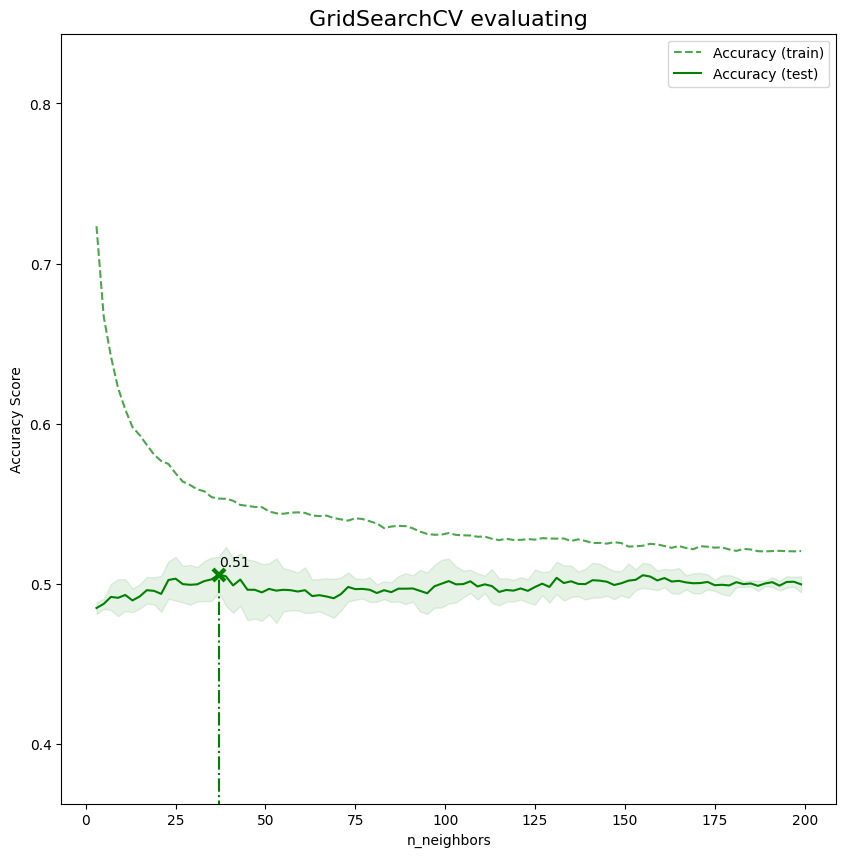

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid = {
    "n_neighbors": range(3, 200, 2)
}
mlflow_train_and_track(KNeighborsClassifier, 'KNN', train_data, 'winner', knn_param_grid, plot=True)

### SVC

In [10]:
from sklearn.svm import LinearSVC
svc_param_grid = {
    'C': np.arange(0.1, 100.0, 4.0)
}
mlflow_train_and_track(LinearSVC, 'SVC', train_data, 'winner', svc_param_grid, {"random_state": 0})

Trained SVC. Best result of 0.6687 accuracy was achieved with the params: 'C': 88.09999999999998


Successfully registered model 'SVC'.
Created version '1' of model 'SVC'.


### Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
random_forest_param_grid = {
    "n_estimators": range(10, 500, 50),
    "max_depth": range(1, 100, 20),
    "min_samples_leaf": range(1, 30, 5)
}
mlflow_train_and_track(RandomForestClassifier, "RandomForest", train_data, "winner", random_forest_param_grid, {"random_state": 0})

Trained RandomForest. Best result of 0.6755 accuracy was achieved with the params: 'max_depth': 21, 'min_samples_leaf': 11, 'n_estimators': 210


Successfully registered model 'RandomForest'.
Created version '1' of model 'RandomForest'.


### MLP

In [12]:
from sklearn.neural_network import MLPClassifier
mlp_param_grid = {
    'alpha': np.arange(0.1, 10.0, 0.5),
    'max_iter': np.arange(100, 1000, 100)
}
mlflow_train_and_track(MLPClassifier, 'MLP', train_data, 'winner', mlp_param_grid, {"random_state": 0})

Trained MLP. Best result of 0.5550 accuracy was achieved with the params: 'alpha': 7.6, 'max_iter': 100


Successfully registered model 'MLP'.
Created version '1' of model 'MLP'.
